# Name: Aafaq Iqbal Khan   Student ID: x20108851

In [1]:
import findspark

In [2]:
#findspark.init("/usr/local/spark")

In [3]:
import pyspark
#from pyspark import SparkContext

In [4]:
from pyspark import SparkContext
from pyspark.sql import SparkSession


In [5]:
#pip install wordcloud

In [33]:
import seaborn as sns
import re
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
from textblob import TextBlob

In [7]:
#SparkSession.stop(spark)
spark=SparkSession.builder.master("local").appName("first").getOrCreate()

In [8]:
# just for checking the spark
sc = spark.sparkContext
nums = sc.parallelize([1, 2, 3, 4])
squared = nums.map(lambda x: x * x).collect()
for num in squared:
    print("%i " % (num))

1 
4 
9 
16 


## Load the file from HDFS

In [9]:
df_ratings = spark.read.csv("/user/hduser/projectData/DIAdata/tripadvisor_reviews_ratings1.csv", header=True, sep=',', inferSchema=True)

In [10]:
df_ratings.printSchema()

root
 |-- Hotel ID: integer (nullable = true)
 |-- User ID: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Overall Rating: string (nullable = true)
 |-- Value Rating: integer (nullable = true)
 |-- Rooms Rating: integer (nullable = true)
 |-- Location Rating: integer (nullable = true)
 |-- Cleanliness Rating: integer (nullable = true)
 |-- Front Desk Rating: integer (nullable = true)
 |-- Service Rating: integer (nullable = true)
 |-- Business Service Rating: integer (nullable = true)



In [11]:
df_reviews = spark.read.csv("/user/hduser/projectData/DIAdata/tripadvisor_reviews_text.csv", header=True, sep=',', inferSchema=True)


In [12]:
df_reviews.printSchema()

root
 |-- Hotel ID: integer (nullable = true)
 |--  User ID: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Review Text: string (nullable = true)



In [50]:
df_listing_details = spark.read.csv("hdfs://localhost:54310/projectData/DIAdata/restaurants data from tripadvisor.csv", header=True, sep=',', inferSchema=True)

In [45]:
df_listing_details.printSchema()

root
 |-- ID_TA: string (nullable = true)
 |-- name: string (nullable = true)
 |-- closed: string (nullable = true)
 |-- inactive: string (nullable = true)
 |-- name_changed: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- claimed: string (nullable = true)
 |-- primary_cus: string (nullable = true)
 |-- city: string (nullable = true)
 |-- cuisines: string (nullable = true)
 |-- special_diets: string (nullable = true)
 |-- pricing: string (nullable = true)
 |-- rank: string (nullable = true)
 |-- city_rest_count: string (nullable = true)
 |-- is_website: string (nullable = true)
 |-- photo_count: string (nullable = true)
 |-- is_video: string (nullable = true)
 |-- cus_rest_rank: string (nullable = true)
 |-- cus_rest_count: string (nullable = true)
 |-- address: string (nullable = true)
 |-- mail: string (nullable = true)
 |-- tel: string (nullable = true)
 |-- review_number: string (nullable = true)
 |-- reviews: string (nullable = true)
 |-- review_dates: string (

In [ ]:
listing=df_listing_details.toPandas()

### Check for Missing value

In [19]:
from pyspark.sql.functions import isnan, when, count, col
df_ratings.select([count(when(isnan(c), c)).alias(c) for c in df_ratings.columns]).take(5)

[Row(Hotel ID=0, User ID=0, Price=0, Location=0, Overall Rating=0, Value Rating=0, Rooms Rating=0, Location Rating=0, Cleanliness Rating=0, Front Desk Rating=0, Service Rating=0, Business Service Rating=0)]

# Top 7 cities where users are most satisfied with restaurants

In [15]:
df_ratings.groupby("Overall Rating").count().show()

+--------------+-----+
|Overall Rating|count|
+--------------+-----+
|          null|    1|
|             1| 1587|
|             3| 2092|
|             5| 7377|
|             4| 6027|
|             2| 1777|
|             0|  150|
+--------------+-----+



In [20]:
neg_df_ratings= df_ratings[df_ratings["Overall Rating"]==1].select('Overall Rating','Location')

pos_df_ratings= df_ratings[df_ratings["Overall Rating"]==5].select('Overall Rating','Location')

In [22]:
neg_df_ratings.show(5)
pos_df_ratings.show(5)

+--------------+------------------+
|Overall Rating|          Location|
+--------------+------------------+
|             1|Seattle Washington|
|             1|Seattle Washington|
|             1|Seattle Washington|
|             1|Seattle Washington|
|             1|Seattle Washington|
+--------------+------------------+
only showing top 5 rows

+--------------+------------------+
|Overall Rating|          Location|
+--------------+------------------+
|             5|Seattle Washington|
|             5|Seattle Washington|
|             5|Seattle Washington|
|             5|Seattle Washington|
|             5|Seattle Washington|
+--------------+------------------+
only showing top 5 rows



Text(0.5, 1.0, 'Top 7 cities where users are most satisfied with restaurants')

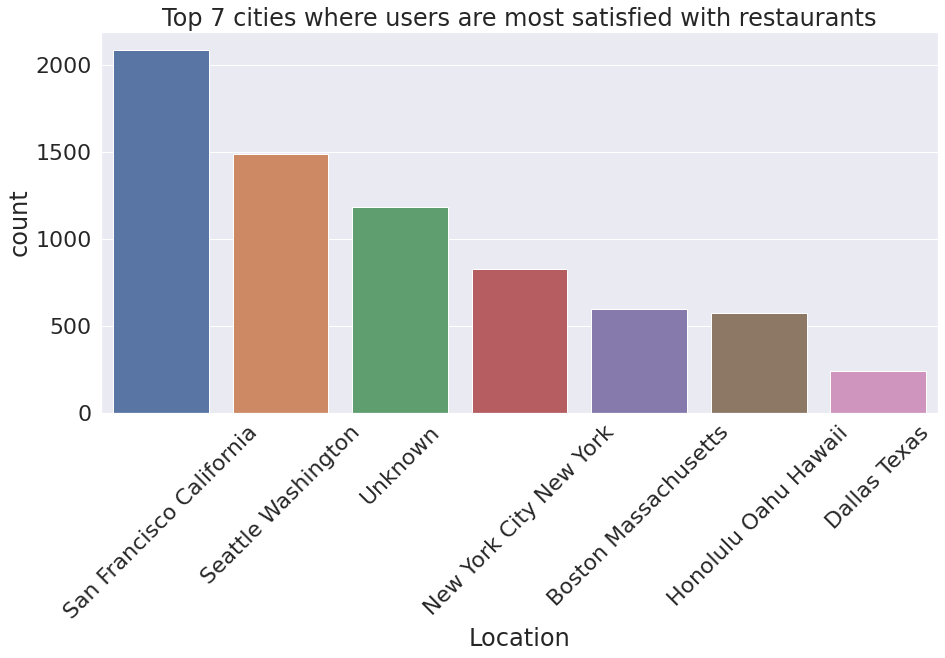

In [25]:
#top 7 cities with most negative reviews
top_cities_pos= pos_df_ratings.groupby("Location").count()
top_cities_pos=top_cities_pos.sort('count',ascending=False)
top_cities_pos=top_cities_pos.limit(7).toPandas()

plt.figure(figsize=(15,7))
sns.barplot(x='Location', y='count', data=top_cities_pos)
sns.set(font_scale=2)
plt.xticks(rotation=45)
plt.title("Top 7 cities where users are most satisfied with restaurants")

# Top 7 cities where users are least satisfied with restaurants

Text(0.5, 1.0, 'Top 7 cities where users are least satisfied with restaurants')

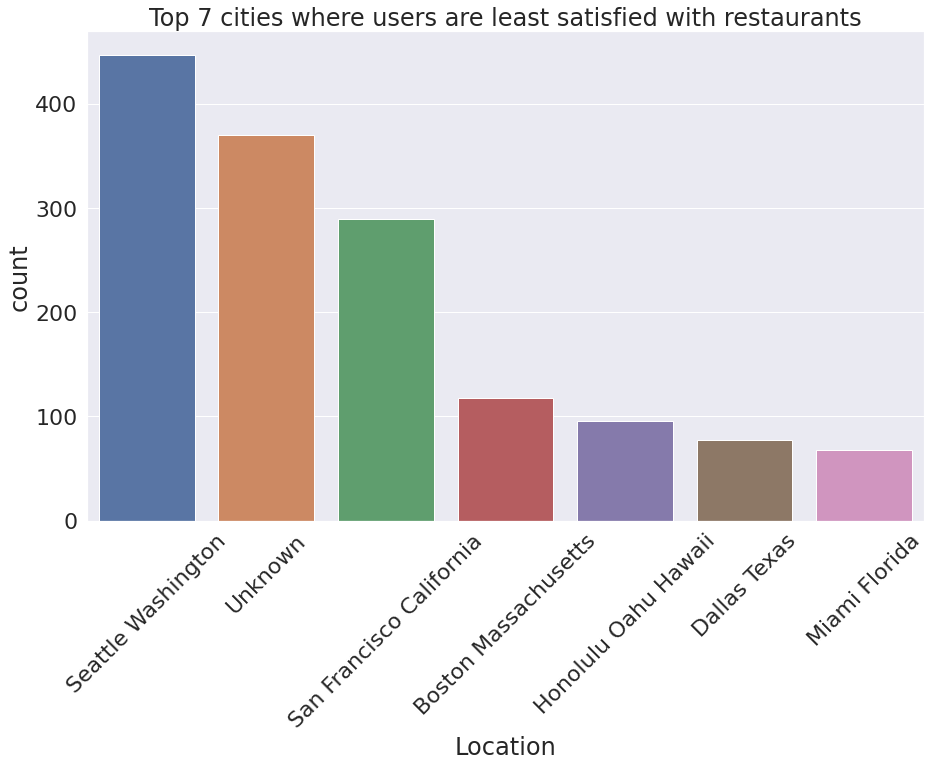

In [24]:
#top 7 cities with most negative reviews
top_cities_neg= neg_df_ratings.groupby("Location").count()
top_cities_neg=top_cities_neg.sort('count',ascending=False)
top_cities_neg=top_cities_neg.limit(7).toPandas()

plt.figure(figsize=(15,9))
sns.set(font_scale=2)
sns.barplot(x='Location', y='count', data=top_cities_neg)
plt.xticks(rotation=45)
plt.title("Top 7 cities where users are least satisfied with restaurants")

# Analysis of the reviews based on rating

### join the 2 datasets. 
because one has ratings and other has their review's text

In [13]:
ratings=df_ratings.toPandas()
reviews=df_reviews.toPandas()

In [14]:
df_combine=ratings.join(reviews,on='Hotel ID', how='inner', rsuffix='new')

In [16]:
df_combine.columns

Index(['Hotel ID', 'User ID', 'Price', 'Location', 'Overall Rating',
       'Value Rating', 'Rooms Rating', 'Location Rating', 'Cleanliness Rating',
       'Front Desk Rating', 'Service Rating', 'Business Service Rating',
       'Hotel IDnew', ' User ID', 'Date', 'Review Text'],
      dtype='object')

#### Which Frequent words were used by satisfied users in their reviews.

We select reviews from our combined dataset which had rating of 5 out 5. This will be considered as Positive reviews

In [17]:
positive_reviews=df_combine[df_combine['Overall Rating']=='5'][['Overall Rating','Review Text']]

In [18]:
positive_reviews.head()

,Overall Rating,Review Text
0,5,Great location; clean and friendly Stayed here...
3,5,Great location; clean and friendly Stayed here...
4,5,Great location; clean and friendly Stayed here...
7,5,Great location; clean and friendly Stayed here...
8,5,Great location; clean and friendly Stayed here...


In [19]:
positive_reviews.describe()

,Overall Rating,Review Text
count,58546,58546
unique,1,1005
top,5,Stay Here My wife and I stayed here after I re...
freq,58546,1725


Check for Nan and Null values

In [20]:
positive_reviews.isna().sum()

Overall Rating    0
Review Text       0
dtype: int64

In [21]:
positive_reviews.isnull().sum()

Overall Rating    0
Review Text       0
dtype: int64

#### Now remove punctuations, Digits and special characters

In [22]:
def remove_punc(line):
    return re.sub('[^A-Za-z]+',' ',line).lower()

In [23]:
positive_reviews['clean_reviews']= positive_reviews['Review Text'].apply(remove_punc)
positive_reviews[['clean_reviews','Review Text']]

,clean_reviews,Review Text
0,great location clean and friendly stayed here ...,Great location; clean and friendly Stayed here...
3,great location clean and friendly stayed here ...,Great location; clean and friendly Stayed here...
4,great location clean and friendly stayed here ...,Great location; clean and friendly Stayed here...
7,great location clean and friendly stayed here ...,Great location; clean and friendly Stayed here...
8,great location clean and friendly stayed here ...,Great location; clean and friendly Stayed here...
...,...,...
246391,la situaci n del hotel showreview full,LA SITUACI脫N DEL HOTEL... showReview(11390927;...
246394,la situaci n del hotel showreview full,LA SITUACI脫N DEL HOTEL... showReview(11390927;...
246396,la situaci n del hotel showreview full,LA SITUACI脫N DEL HOTEL... showReview(11390927;...
246397,la situaci n del hotel showreview full,LA SITUACI脫N DEL HOTEL... showReview(11390927;...


Stop words removal

In [25]:
stop_words= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

In [28]:
#import nlkt

# from nlkt.util import ngrams
#from nlkt.corpus import stopwords
# def tokenize_without_stopwords(line):
#     tokens=nlkt.tokenize.word_tokenize(line)
#     tokens_no_stop = [w for w in tokens if w not in stopwords.words('english')]
#     return " ".join(tokens_no_stop)

def tokenize_without_stopwords(line):
    blob = TextBlob(line)
    lista = [word for word in blob.words if word not in stop_words]
    return" ".join(lista)
    

In [29]:
positive_reviews['final_reviews']= positive_reviews['clean_reviews'].apply(tokenize_without_stopwords)

In [30]:
positive_reviews[['clean_reviews','final_reviews']]

,clean_reviews,final_reviews
0,great location clean and friendly stayed here ...,great location clean friendly stayed three nig...
3,great location clean and friendly stayed here ...,great location clean friendly stayed three nig...
4,great location clean and friendly stayed here ...,great location clean friendly stayed three nig...
7,great location clean and friendly stayed here ...,great location clean friendly stayed three nig...
8,great location clean and friendly stayed here ...,great location clean friendly stayed three nig...
...,...,...
246391,la situaci n del hotel showreview full,la situaci n del hotel showreview full
246394,la situaci n del hotel showreview full,la situaci n del hotel showreview full
246396,la situaci n del hotel showreview full,la situaci n del hotel showreview full
246397,la situaci n del hotel showreview full,la situaci n del hotel showreview full


#### New lets look at top 50 words used by satisfied users in their reviews 

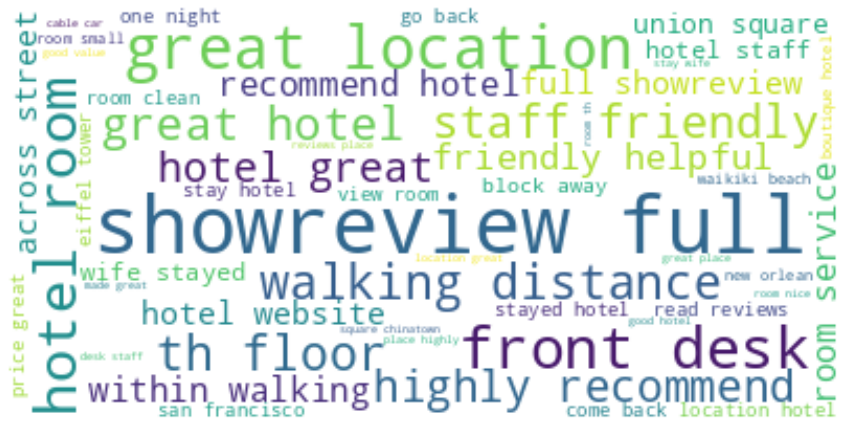

In [34]:
text= " ".join(str(each) for each in positive_reviews.final_reviews)
wordcloud= WordCloud(max_words= 50, background_color="white").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation= "bilinear")
plt.axis("off")
plt.show()
pass

#### Identify the common reasons dissatisfaction or words used by unsatisfied users in their reviews.

We select reviews from our combined dataset which had rating of 1 out 5 and 2 out of 5. This will be considered as negative reviews

In [94]:
negitive_reviews=listing[(listing['rating']== '1.0') | (listing['rating']== '2.0')][['rating','reviews']]
negitive_reviews.describe()

,rating,reviews
count,3594,651
unique,2,649
top,1.0,the supervisor was rude i was forced to take d...
freq,2405,2


In [95]:
negitive_reviews.head()

,rating,reviews
5,2.0,None
54,1.0,None
56,1.0,None
191,1.0,None
192,1.0,None


##### There are some none values that we need to remove

In [97]:
negitive_reviews['reviews']=negitive_reviews['reviews'].astype(str)
negitive_reviews=negitive_reviews[negitive_reviews['reviews']!= 'None']
negitive_reviews.head()

,rating,reviews
694,2.0,We live near here and have been several times....
1306,1.0,WORST ever pub experience in the whole of UK. ...
1814,2.0,"When I occasionally order out for food, I'm no..."
1855,2.0,Very rude staff and tasteless food
2197,1.0,Yesterday I ordered two Garlic Naan and saag p...


Check for Nan and Null values

In [98]:
negitive_reviews.isna().sum()

rating     0
reviews    0
dtype: int64

In [99]:
negitive_reviews.isnull().sum()

rating     0
reviews    0
dtype: int64

#### Now remove punctuations, Digits and special characters

In [100]:
negitive_reviews['clean_reviews']= negitive_reviews['reviews'].apply(remove_punc)
negitive_reviews[['clean_reviews','reviews']]

,clean_reviews,reviews
694,we live near here and have been several times ...,We live near here and have been several times....
1306,worst ever pub experience in the whole of uk f...,WORST ever pub experience in the whole of UK. ...
1814,when i occasionally order out for food i m not...,"When I occasionally order out for food, I'm no..."
1855,very rude staff and tasteless food,Very rude staff and tasteless food
2197,yesterday i ordered two garlic naan and saag p...,Yesterday I ordered two Garlic Naan and saag p...
...,...,...
237764,used uber eats fornthe first time today never ...,"Used uber eats fornthe first time today, never..."
237768,i went to this shop to get a meal for me and a...,I went to this shop to get a meal for me and a...
238143,this place offers a very delicious vegan pizza...,This place offers a very delicious Vegan Pizza...
238169,nothing about this place was good the food was...,Nothing about this place was good. The food wa...


Stop words removal

In [101]:
negitive_reviews['final_reviews']= negitive_reviews['clean_reviews'].apply(tokenize_without_stopwords)

In [102]:
negitive_reviews[['clean_reviews','final_reviews']]

,clean_reviews,final_reviews
694,we live near here and have been several times ...,live near several times usually pretty good la...
1306,worst ever pub experience in the whole of uk f...,worst ever pub experience whole uk food us app...
1814,when i occasionally order out for food i m not...,occasionally order food really looking forward...
1855,very rude staff and tasteless food,rude staff tasteless food
2197,yesterday i ordered two garlic naan and saag p...,yesterday ordered two garlic naan saag paneer ...
...,...,...
237764,used uber eats fornthe first time today never ...,used uber eats fornthe first time today never ...
237768,i went to this shop to get a meal for me and a...,went shop get meal homeless woman checked outs...
238143,this place offers a very delicious vegan pizza...,place offers delicious vegan pizza toppings ch...
238169,nothing about this place was good the food was...,nothing place good food old soggy beyond disgu...


#### New lets look at top 50 words used by unsatisfied users in their reviews 

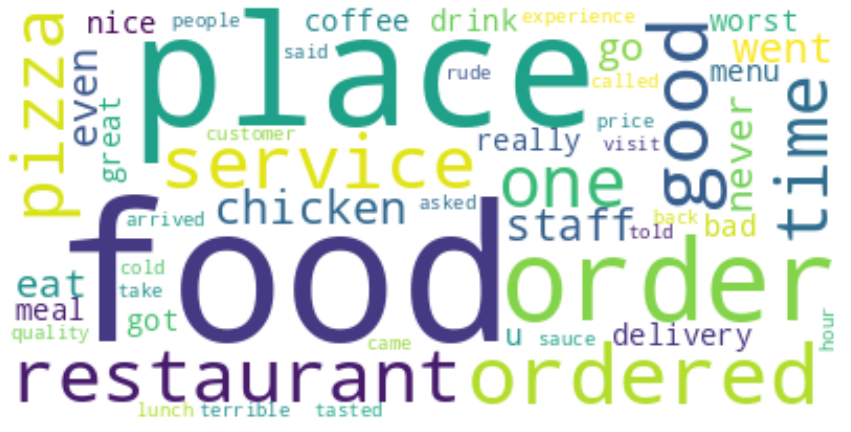

In [103]:
text= " ".join(str(each) for each in negitive_reviews.final_reviews)
wordcloud= WordCloud(max_words= 50, background_color="white").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation= "bilinear")
plt.axis("off")
plt.show()
pass